# DNN: analysis with Keras of 2D data

In [89]:
import numpy        as     np
from   keras.models import Sequential # basic NN
from   keras.layers import Dense, Dropout
#dense : normal layer(?)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

%run nonlinear_function.py

# training data
perc_train = 0.8

4000
2
[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 0.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 0.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 1.0
data: 4000
train: 3200


<function matplotlib.pyplot.show(close=None, block=None)>

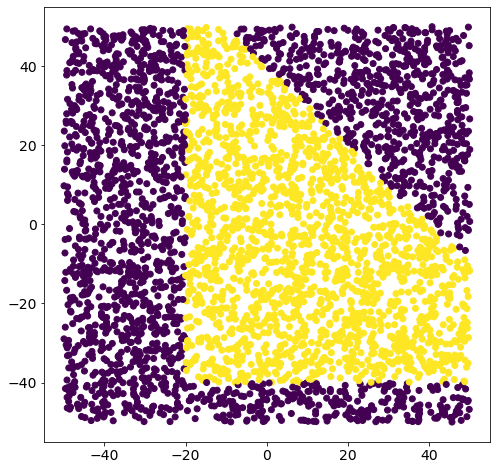

In [91]:
# Keras works with numpy arrays: just use them from the start
TYPE = 1
x    = np.loadtxt( filename( 'data',   TYPE),   delimiter = ' ' )
y    = np.loadtxt( filename( 'labels', TYPE), delimiter = ' ' )
N    = len( x )
print( N ) 

# dim of a sample
L = len( x[0] )
print( L )

for i in range (10):
    print(x[i], y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize = (8,8))
plt.scatter(x[:,0], x[:,1], c = y )
plt.show


## Split training and test data

In [78]:
(x_train, y_train) = (x[0:N_train], y[0:N_train])
(x_valid, y_valid) = (x[N_train:], y[N_train:])
print("Train:", len(x_train), "\t Validation:", len(x_valid) )

# ADD NOISE
std = 1
noise = np.random.normal(scale = std, size=(N_train, 2))

x_train_noise = x_train + noise
print(x_train_noise)

Train: 3200 	 Validation: 800
[[-31.81282649 -29.06502881]
 [  6.25306419   8.99873999]
 [ 48.41723255  16.71111552]
 ...
 [-49.58851246 -14.67823052]
 [ 12.63296755 -15.52102618]
 [ 43.16851695  27.44024925]]


## Rescale input data

In [79]:
def Rescale(x):
    # I cal also take away the mean
    #return (x-x.mean())/np.sqrt(x.var())
    return x / 50

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

## Define the model with Keras

In [80]:
# reproducibility
np.random.seed(12345)

CASE = 1

if CASE ==1 :
    model = Sequential()
    #then I continue adding layers
    model.add(Dense(L, input_shape = (L, ), activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    nepoch = 400 # le volte in cui faccio lo scan sul database, keras di default fa lo shuffle dopo ogni epoch e quindi le minibatch sono diverse
    
if CASE ==2 :
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = 'sigmoid'))
    model.add(Dense(3, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    nepoch = 400

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 2)                 6         
                                                                 
 dense_31 (Dense)            (None, 20)                60        
                                                                 
 dense_32 (Dense)            (None, 20)                420       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 21        
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________
None


## Optimization method and cost function

In [81]:
model.compile(loss = 'binary_crossentropy',
              #optimizer = 'RMSprop',
             optimizer = 'adam',
             metrics = ['accuracy'])

## Training

In [82]:
fit = model.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
                validation_data = (x_valid, y_valid),
                verbose = 2)


Epoch 1/400
64/64 - 1s - loss: 0.6770 - accuracy: 0.6222 - val_loss: 0.6670 - val_accuracy: 0.6350 - 663ms/epoch - 10ms/step
Epoch 2/400
64/64 - 0s - loss: 0.6491 - accuracy: 0.6603 - val_loss: 0.6437 - val_accuracy: 0.6313 - 139ms/epoch - 2ms/step
Epoch 3/400
64/64 - 0s - loss: 0.6265 - accuracy: 0.6578 - val_loss: 0.6270 - val_accuracy: 0.6288 - 159ms/epoch - 2ms/step
Epoch 4/400
64/64 - 0s - loss: 0.6029 - accuracy: 0.6644 - val_loss: 0.6036 - val_accuracy: 0.6438 - 140ms/epoch - 2ms/step
Epoch 5/400
64/64 - 0s - loss: 0.5778 - accuracy: 0.6963 - val_loss: 0.5801 - val_accuracy: 0.6500 - 124ms/epoch - 2ms/step
Epoch 6/400
64/64 - 0s - loss: 0.5556 - accuracy: 0.7088 - val_loss: 0.5562 - val_accuracy: 0.6775 - 121ms/epoch - 2ms/step
Epoch 7/400
64/64 - 0s - loss: 0.5310 - accuracy: 0.7325 - val_loss: 0.5390 - val_accuracy: 0.7038 - 141ms/epoch - 2ms/step
Epoch 8/400
64/64 - 0s - loss: 0.5149 - accuracy: 0.7434 - val_loss: 0.5200 - val_accuracy: 0.7287 - 160ms/epoch - 3ms/step
Epoch 9

Epoch 67/400
64/64 - 0s - loss: 0.2829 - accuracy: 0.8694 - val_loss: 0.2664 - val_accuracy: 0.8950 - 110ms/epoch - 2ms/step
Epoch 68/400
64/64 - 0s - loss: 0.2811 - accuracy: 0.8750 - val_loss: 0.2588 - val_accuracy: 0.9062 - 100ms/epoch - 2ms/step
Epoch 69/400
64/64 - 0s - loss: 0.2806 - accuracy: 0.8766 - val_loss: 0.2585 - val_accuracy: 0.8988 - 96ms/epoch - 1ms/step
Epoch 70/400
64/64 - 0s - loss: 0.2747 - accuracy: 0.8788 - val_loss: 0.2511 - val_accuracy: 0.9050 - 103ms/epoch - 2ms/step
Epoch 71/400
64/64 - 0s - loss: 0.2677 - accuracy: 0.8816 - val_loss: 0.2440 - val_accuracy: 0.9175 - 115ms/epoch - 2ms/step
Epoch 72/400
64/64 - 0s - loss: 0.2636 - accuracy: 0.8853 - val_loss: 0.2413 - val_accuracy: 0.9175 - 110ms/epoch - 2ms/step
Epoch 73/400
64/64 - 0s - loss: 0.2614 - accuracy: 0.8838 - val_loss: 0.2457 - val_accuracy: 0.9137 - 102ms/epoch - 2ms/step
Epoch 74/400
64/64 - 0s - loss: 0.2543 - accuracy: 0.8900 - val_loss: 0.2298 - val_accuracy: 0.9237 - 99ms/epoch - 2ms/step
Ep

Epoch 133/400
64/64 - 0s - loss: 0.0552 - accuracy: 0.9766 - val_loss: 0.0273 - val_accuracy: 0.9950 - 141ms/epoch - 2ms/step
Epoch 134/400
64/64 - 0s - loss: 0.0518 - accuracy: 0.9787 - val_loss: 0.0305 - val_accuracy: 0.9925 - 147ms/epoch - 2ms/step
Epoch 135/400
64/64 - 0s - loss: 0.0536 - accuracy: 0.9750 - val_loss: 0.0252 - val_accuracy: 0.9962 - 144ms/epoch - 2ms/step
Epoch 136/400
64/64 - 0s - loss: 0.0514 - accuracy: 0.9791 - val_loss: 0.0260 - val_accuracy: 0.9962 - 120ms/epoch - 2ms/step
Epoch 137/400
64/64 - 0s - loss: 0.0515 - accuracy: 0.9778 - val_loss: 0.0291 - val_accuracy: 0.9937 - 173ms/epoch - 3ms/step
Epoch 138/400
64/64 - 0s - loss: 0.0512 - accuracy: 0.9791 - val_loss: 0.0234 - val_accuracy: 0.9950 - 200ms/epoch - 3ms/step
Epoch 139/400
64/64 - 0s - loss: 0.0536 - accuracy: 0.9775 - val_loss: 0.0249 - val_accuracy: 0.9950 - 133ms/epoch - 2ms/step
Epoch 140/400
64/64 - 0s - loss: 0.0500 - accuracy: 0.9791 - val_loss: 0.0339 - val_accuracy: 0.9925 - 124ms/epoch - 2

Epoch 199/400
64/64 - 0s - loss: 0.0381 - accuracy: 0.9809 - val_loss: 0.0166 - val_accuracy: 0.9962 - 138ms/epoch - 2ms/step
Epoch 200/400
64/64 - 0s - loss: 0.0363 - accuracy: 0.9816 - val_loss: 0.0175 - val_accuracy: 0.9937 - 126ms/epoch - 2ms/step
Epoch 201/400
64/64 - 0s - loss: 0.0359 - accuracy: 0.9806 - val_loss: 0.0205 - val_accuracy: 0.9875 - 102ms/epoch - 2ms/step
Epoch 202/400
64/64 - 0s - loss: 0.0318 - accuracy: 0.9859 - val_loss: 0.0135 - val_accuracy: 0.9975 - 126ms/epoch - 2ms/step
Epoch 203/400
64/64 - 0s - loss: 0.0317 - accuracy: 0.9850 - val_loss: 0.0143 - val_accuracy: 0.9962 - 114ms/epoch - 2ms/step
Epoch 204/400
64/64 - 0s - loss: 0.0342 - accuracy: 0.9841 - val_loss: 0.0198 - val_accuracy: 0.9937 - 114ms/epoch - 2ms/step
Epoch 205/400
64/64 - 0s - loss: 0.0383 - accuracy: 0.9794 - val_loss: 0.0149 - val_accuracy: 0.9962 - 125ms/epoch - 2ms/step
Epoch 206/400
64/64 - 0s - loss: 0.0359 - accuracy: 0.9834 - val_loss: 0.0230 - val_accuracy: 0.9925 - 138ms/epoch - 2

Epoch 265/400
64/64 - 0s - loss: 0.0307 - accuracy: 0.9878 - val_loss: 0.0133 - val_accuracy: 0.9962 - 166ms/epoch - 3ms/step
Epoch 266/400
64/64 - 0s - loss: 0.0258 - accuracy: 0.9900 - val_loss: 0.0156 - val_accuracy: 0.9962 - 129ms/epoch - 2ms/step
Epoch 267/400
64/64 - 0s - loss: 0.0278 - accuracy: 0.9900 - val_loss: 0.0157 - val_accuracy: 0.9912 - 183ms/epoch - 3ms/step
Epoch 268/400
64/64 - 0s - loss: 0.0377 - accuracy: 0.9859 - val_loss: 0.0144 - val_accuracy: 0.9937 - 237ms/epoch - 4ms/step
Epoch 269/400
64/64 - 0s - loss: 0.0264 - accuracy: 0.9912 - val_loss: 0.0170 - val_accuracy: 0.9962 - 171ms/epoch - 3ms/step
Epoch 270/400
64/64 - 0s - loss: 0.0282 - accuracy: 0.9906 - val_loss: 0.0101 - val_accuracy: 0.9987 - 166ms/epoch - 3ms/step
Epoch 271/400
64/64 - 0s - loss: 0.0263 - accuracy: 0.9909 - val_loss: 0.0101 - val_accuracy: 0.9975 - 172ms/epoch - 3ms/step
Epoch 272/400
64/64 - 0s - loss: 0.0411 - accuracy: 0.9831 - val_loss: 0.0180 - val_accuracy: 0.9925 - 208ms/epoch - 3

Epoch 331/400
64/64 - 0s - loss: 0.0286 - accuracy: 0.9897 - val_loss: 0.0096 - val_accuracy: 0.9975 - 92ms/epoch - 1ms/step
Epoch 332/400
64/64 - 0s - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.0137 - val_accuracy: 0.9937 - 105ms/epoch - 2ms/step
Epoch 333/400
64/64 - 0s - loss: 0.0267 - accuracy: 0.9903 - val_loss: 0.0101 - val_accuracy: 0.9950 - 130ms/epoch - 2ms/step
Epoch 334/400
64/64 - 0s - loss: 0.0250 - accuracy: 0.9906 - val_loss: 0.0129 - val_accuracy: 0.9950 - 131ms/epoch - 2ms/step
Epoch 335/400
64/64 - 0s - loss: 0.0209 - accuracy: 0.9947 - val_loss: 0.0160 - val_accuracy: 0.9937 - 101ms/epoch - 2ms/step
Epoch 336/400
64/64 - 0s - loss: 0.0292 - accuracy: 0.9897 - val_loss: 0.0113 - val_accuracy: 0.9975 - 125ms/epoch - 2ms/step
Epoch 337/400
64/64 - 0s - loss: 0.0311 - accuracy: 0.9887 - val_loss: 0.0115 - val_accuracy: 0.9950 - 129ms/epoch - 2ms/step
Epoch 338/400
64/64 - 0s - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0186 - val_accuracy: 0.9962 - 103ms/epoch - 2m

64/64 - 0s - loss: 0.0322 - accuracy: 0.9862 - val_loss: 0.0111 - val_accuracy: 0.9962 - 149ms/epoch - 2ms/step
Epoch 397/400
64/64 - 0s - loss: 0.0318 - accuracy: 0.9878 - val_loss: 0.0129 - val_accuracy: 0.9937 - 113ms/epoch - 2ms/step
Epoch 398/400
64/64 - 0s - loss: 0.0241 - accuracy: 0.9934 - val_loss: 0.0081 - val_accuracy: 0.9987 - 94ms/epoch - 1ms/step
Epoch 399/400
64/64 - 0s - loss: 0.0236 - accuracy: 0.9909 - val_loss: 0.0110 - val_accuracy: 0.9950 - 98ms/epoch - 2ms/step
Epoch 400/400
64/64 - 0s - loss: 0.0230 - accuracy: 0.9909 - val_loss: 0.0147 - val_accuracy: 0.9950 - 99ms/epoch - 2ms/step


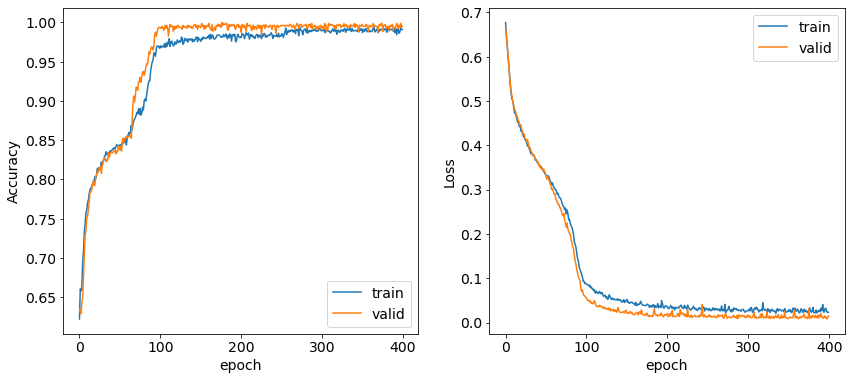

In [83]:
fig, AX = plt.subplots (1, 2, figsize = (14, 6.))
ax = AX[0]
ax.plot(fit.history['accuracy'], label = 'train')
ax.plot(fit.history['val_accuracy'], label = 'valid')
ax.set_xlabel('epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax = AX[1]
ax.plot(fit.history['loss'], label = 'train')
ax.plot(fit.history['val_loss'], label = 'valid')
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
ax.legend()

In [84]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model.predict(grid_r)

51 2601
[50. 50.]


<function matplotlib.pyplot.show(close=None, block=None)>

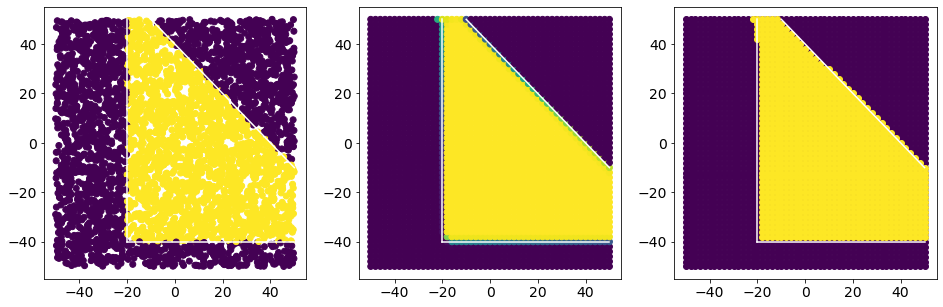

In [85]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
boundaries()
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
boundaries()
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()
plt.show
plt.show